In [1]:
# To add a new cell, type '# %%'
# To add a new markdown cell, type '# %% [markdown]'
# %%
from lightgbm import train
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.fftpack import dct
from scipy.fftpack import idct



 #### -- 모델 준비

In [2]:
# 원전 내부의 충돌체 정보를 네개의 센서 정보만으로 특정해내기
# 데이터 출처 : https://dacon.io/competitions/official/235614/overview/description/
train_features = pd.read_csv('D:/Data/KAERI_dataset/train_features.csv')
train_target = pd.read_csv('D:/Data/KAERI_dataset/train_target.csv')



In [3]:
train_features.shape, train_target.shape



((1050000, 6), (2800, 5))

In [4]:
train_features.head()

,id,Time,S1,S2,S3,S4
0,0,0.000000,0.0,0.0,0.0,0.0
1,0,0.000004,0.0,0.0,0.0,0.0
2,0,0.000008,0.0,0.0,0.0,0.0
3,0,0.000012,0.0,0.0,0.0,0.0
4,0,0.000016,0.0,0.0,0.0,0.0


In [5]:
train_features[['S1','S2','S3','S4']].max()

S1    3865086.0
S2    3865086.0
S3    3655237.0
S4    3687344.0
dtype: float64

In [6]:
train_features[['S1','S2','S3','S4']].min()

S1   -5596468.0
S2   -5596468.0
S3   -2772952.0
S4   -6069645.0
dtype: float64

In [7]:
train_features[['S1','S2','S3','S4']].mean()

S1    -405.098322
S2    -405.098322
S3   -1334.343465
S4   -1605.663879
dtype: float64

In [8]:
train_features[['S1','S2','S3','S4']].mean().mean()

-937.55099730381

In [9]:
train_features[np.abs(train_features['S1'])>937.55 ]


,id,Time,S1,S2,S3,S4
38,0,0.000152,1179.7070,1179.7070,0.038488,20.615840
40,0,0.000160,-970.4157,-970.4157,0.266737,0.062216
41,0,0.000164,-1586.4890,-1586.4890,0.633564,-26.466910
43,0,0.000172,1704.8890,1704.8890,2.788320,-70.844950
44,0,0.000176,2022.9030,2022.9030,5.123281,-57.506970
...,...,...,...,...,...,...
1049995,2799,0.001480,-89256.3200,-164614.6000,48186.290000,-147910.200000
1049996,2799,0.001484,-29233.4400,-179404.2000,109534.400000,-111591.100000
1049997,2799,0.001488,37147.2500,-190011.7000,178781.100000,-86836.780000
1049998,2799,0.001492,98278.5000,-190771.4000,245726.700000,-75660.000000


In [10]:
def find_firt_min_amp(data0,min_amp=937.55):
    data = data0.copy()
    cond_min = (np.abs(data['S1']) > min_amp) | (np.abs(data['S2']) > min_amp) | (np.abs(data['S3']) > min_amp) | (np.abs(data['S4']) > min_amp)
    data_active = data[cond_min]
    data_active = data_active.drop_duplicates(['id'],keep='first')

    # for s in ['S1','S2','S3','S4']:
    #         cond_t = (train_features[s] > 937.55)
    #         active_time = data[cond_t].drop_duplicates(['id'],keep='first')[['id','Time']]
    #         active_time['Time'] = (active_time['Time']*10**6).astype('int')
    #         active_time.columns = ['id','active_time_'+s]
    #         data_active = data_active.merge(active_time,on='id')
    return data_active

In [11]:
(np.abs(find_firt_min_amp(train_features,min_amp=10000)['S4'])>10000).sum()

1351

<AxesSubplot:xlabel='Time', ylabel='S4'>

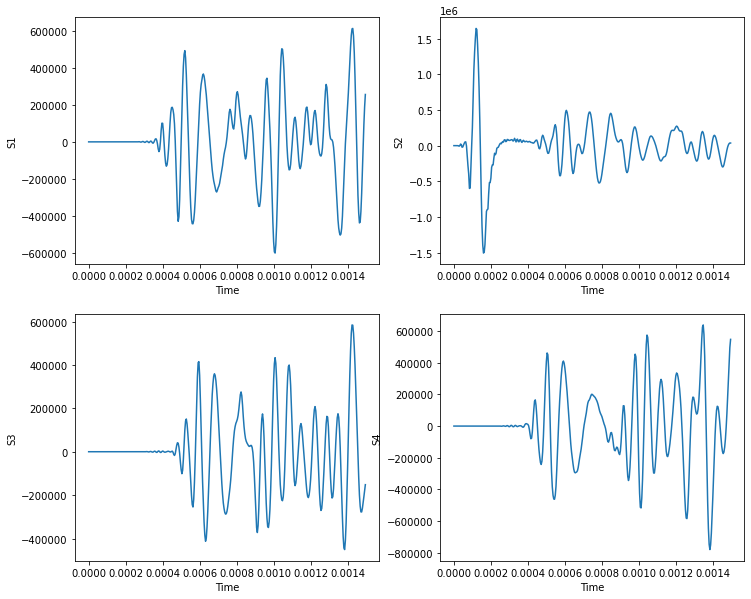

In [12]:
# 같은 인덱스(같은 충돌체)의 센서 정보를 시각화 해서 비교
# 이 파장들을 푸리에 트랜스폼 시켜서, 근사적으로 amplitude가 큰 경우만 몇가지 추려내 feature로 쓸 수 있을까?
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
sns.lineplot(data=train_features.loc[train_features['id']==10],x='Time',y='S1')

plt.subplot(2,2,2)
sns.lineplot(data=train_features.loc[train_features['id']==10],x='Time',y='S2')

plt.subplot(2,2,3)
sns.lineplot(data=train_features.loc[train_features['id']==10],x='Time',y='S3')

plt.subplot(2,2,4)
sns.lineplot(data=train_features.loc[train_features['id']==10],x='Time',y='S4')

In [13]:
train_features.loc[train_features['id']==10,'Time'].shape[0]

375

In [14]:
train_features.loc[train_features['id']==10,'S1'].values

array([ 0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
        0.000000e+00,  7.289906e-08,  5.706967e-07,  2.938536e-06,
        1.663324e-05,  7.646967e-05,  3.486072e-04,  1.445043e-03,
        5.365218e-03,  1.832027e-02,  5.737649e-02,  1.691780e-01,
        4.581975e-01,  1.161751e+00,  2.719724e+00,  5.836855e+00,
        1.154249e+01,  2.030301e+01,  3.208792e+01,  4.273950e+01,
        4.578627e+01,  3.003994e+01, -1.232607e+01, -8.296474e+01,
       -1.512540e+02, -1.920757e+02, -1.572109e+02, -4.281068e+01,
        8.394468e+01,  1.546614e+02,  1.087522e+02,  4.159132e+00,
       -1.678964e+01,  8.693779e+01,  1.859826e+02,  1.325555e

In [15]:
# scipy에서 Discrete Cosine Transform을 사용, 원하는 만큼만 잘라낼 수 있게 함수 설정
def fourier_trsf(data,sensor,id=10,cutoff=65):
	cond_id = data['id']==id
	wave = data.loc[cond_id,sensor].values
	time = data.loc[cond_id,'Time']
	fft_wave = dct(wave, type=2,n=time.shape[0])
	freq = np.fft.fftfreq(wave.size,d=0.000004)
	cw = np.copy(fft_wave)
	cw[cutoff:]=0
	fft_wave_2 = np.real(idct(cw))
	
	return {"cw":cw[:cutoff],"fft":fft_wave, "freq":freq, "fft_cutoff":fft_wave_2, "time":time, "wave":wave}

In [16]:
amp_w_0_s1 = fourier_trsf(data=train_features,sensor='S1',id=0,cutoff=1)['fft'][0:40]
freq_w_0_s1 = fourier_trsf(data=train_features,sensor='S1',id=0,cutoff=1)['freq'][0:40]
df_w_0_s1 = pd.DataFrame([freq_w_0_s1,amp_w_0_s1]).T
df_w_0_s1.columns = ['frequency','amplitude']
df_w_0_s1
# frequency는 id별로 전부 시간 기록 간격이 동일 하기 때문에 다르지 않음
# frequency정보는 amplitude를 기록하는 순서만 잘 지켜 주면 됨!
# 대신 문제는... 적어도 40개는 잡아줘야 한다는 건데, 이러면 특성만 160개 추가
# id=10 같이 복잡한 케이스는... 50개는 잡아줘야 하네 ㅋㅋ 200개 추가요!
# 전부 잡을 수는 없다. 일단 40개 정도만 넣어주자
# 꼭 다 넣을 필요는 없잖아? 제일 amplitude가 큰것만 넣어봐?

# 전체 id에 대해서, 가장 큰 apmlitude를 갖는 frequency를 30개씩만 뽑기
# 그렇게 뽑은 목록들을 set로 만들어서 교집합이 존재하는지 확인
# 만약에 꽤 많은 교집합이 남는다면, 그게 이 원자로 내부의 형태에 맞는 주파수일 가능성이 높다
# 해당 주파수들만 뽑아서 feature로 삼기!

,frequency,amplitude
0,0.000000,-2.312284e+05
1,666.666667,6.609213e+05
2,1333.333333,-2.045210e+06
3,2000.000000,2.221783e+06
4,2666.666667,1.755566e+06
5,3333.333333,-3.613818e+06
6,4000.000000,-2.947640e+06
7,4666.666667,3.450157e+06
8,5333.333333,5.556081e+06
9,6000.000000,8.788646e+03


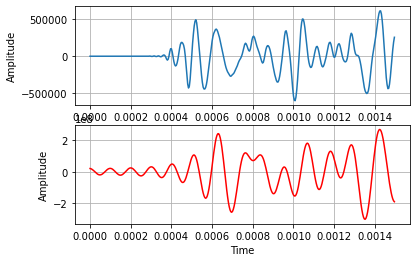

In [17]:
w0 = fourier_trsf(data=train_features,sensor='S1',id=10,cutoff=30)

fig, ax = plt.subplots(2, 1)

ax[0].plot(w0['time'], w0['wave'])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)

ax[1].plot(w0['time'], w0['fft_cutoff'], 'r') 
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Amplitude')
ax[1].grid(True)

plt.show()

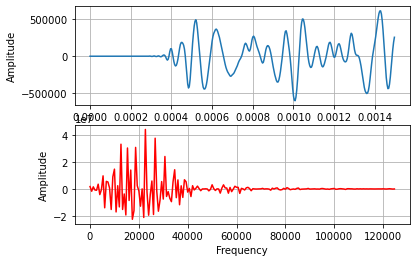

In [18]:
w0 = fourier_trsf(data=train_features,sensor='S1',id=10,cutoff=30)

fig, ax = plt.subplots(2, 1)

ax[0].plot(w0['time'], w0['wave'])
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)

ax[1].plot(w0['freq'][:int(375/2)+1], w0['fft'][:int(375/2)+1], 'r') 
ax[1].set_xlabel('Frequency')
ax[1].set_ylabel('Amplitude')
ax[1].grid(True)

plt.show()

In [19]:
amp_w_0_s1 = fourier_trsf(data=train_features,sensor='S1',id=0,cutoff=1)['fft'][0:int(375/2)+1]
freq_w_0_s1 = fourier_trsf(data=train_features,sensor='S1',id=0,cutoff=1)['freq'][0:int(375/2)+1]
df_w_0_s1 = pd.DataFrame([freq_w_0_s1,amp_w_0_s1]).T
df_w_0_s1.columns = ['frequency','amplitude']
df_w_0_s1['abs_amp'] = abs(df_w_0_s1['amplitude'])
freq_set = set()
set_0 = set(list(df_w_0_s1.sort_values(by='abs_amp',ascending=False).head(30).index))
# 굳이 frequency로 뽑을 필요도 없겠다. 순서만 알면 됨. 그냥 index번호를 뽑아버리자

In [20]:
# 함수로 짜보자!
# 상위 40개에서 겹치는 걸 찾으려고 하면... 당연하지만
# 없다! 그런건 없어! 
# 하지만 방법을 반대로 바꿔보자, 상위 40개에 절대 들어오지 않는 freq는 있을까?
# 공간이 제한되어 있기 때문에, 거의 나타나지 않는 freq가 있을 수 있다!
def find_unique_freq(data0,head=40):
    data = data0.copy()
    id_list = np.array(data['id'].unique())
    set_dict = {}
    n = data[data['id']==0].shape[0]
    nn = int(n/2)+1

    for s in ['S1','S2','S3','S4']:
        min_set = set(range(0,nn))
        for i in id_list:
            fft_wave = fourier_trsf(data=data,sensor=s,id=i)
            freq = fft_wave['freq'][0:nn]
            amp = fft_wave['fft'][0:nn]
            abs_amp = abs(amp)

            df_wave = pd.DataFrame([freq,amp,abs_amp]).T
            df_wave.columns = ['freq','amp','abs_amp']
            set_i = set(df_wave.sort_values(by='abs_amp',ascending=False).head(head).index)

            min_set = min_set - set_i

        set_dict[s]=min_set
    return set_dict


In [21]:
# rmv_freq = find_unique_freq(train_features)
# 계산이 좀 걸리지만, 이정도는 오케이

In [22]:
# 좋아! 있다! 그것도 꽤 많다! 96개
# 일단 188개에서, 96개를 빼버리자, 그러면 남는게 92개
# tot_rmv_freq = rmv_freq['S1'] & rmv_freq['S2'] & rmv_freq['S3'] & rmv_freq['S4']
# len(tot_rmv_freq)

In [23]:
# 한번 더 해보자, 이번엔 상의 30개에 들어오지 않는 freq를 찾아서 제외시키자
# rmv_freq_und30 = find_unique_freq(train_features,head=30)
# tot_rmv_freq_und30 = rmv_freq_und30['S1'] & rmv_freq_und30['S2'] & rmv_freq_und30['S3'] & rmv_freq_und30['S4']
# len(tot_rmv_freq_und30)
# 오케이! 108개다. 이만큼을 제외 시키면, 80개가 남는다
# 이정도면 해볼만도...? 

In [24]:
# 게다가 이겈ㅋㅋㅋ 0~79까지가 딱 남았네
# freq_idx_80 = np.array(set(range(0,188)) - tot_rmv_freq_und30)
# freq_idx_80

In [25]:
# 한번만 더 해보자! 상위 20개
# 112개 제외라, 76개가 남는다. 딱히 더 나아지진 않네
# rmv_freq_und20 = find_unique_freq(train_features,head=20)
# tot_rmv_freq_und20 = rmv_freq_und20['S1'] & rmv_freq_und20['S2'] & rmv_freq_und20['S3'] & rmv_freq_und20['S4']
# len(tot_rmv_freq_und20)

In [26]:
# freq_idx_76 = np.array(set(range(0,188)) - tot_rmv_freq_und20)
# freq_idx_76

In [27]:
# 실험 삼아 하나만 더 해보자, 상위 5개!
# rmv_freq_und5 = find_unique_freq(train_features,head=5)
# tot_rmv_freq_und5 = rmv_freq_und5['S1'] & rmv_freq_und5['S2'] & rmv_freq_und5['S3'] & rmv_freq_und5['S4']
# len(tot_rmv_freq_und5)

In [28]:
# freq_idx_60 = np.array(set(range(0,188)) - tot_rmv_freq_und5)
# freq_idx_60

In [29]:
# 65번째 까지(0~64) 킵해보자
# 일단 feature로 만들어서 넣어주는 함수를 짜자
# column이름은 f1_0~f4_65같은 식으로 넣기
def fourier_feature(data0,cutoff=65):
    data = data0.copy()
    id_list = np.array(data['id'].unique())
    df_id = pd.DataFrame(id_list,columns=['id'])
    df_list = [df_id]

    for s in ['S1','S2','S3','S4']:
        df_s = []
        for i in id_list:
            fft_wave = fourier_trsf(data=data,sensor=s,id=i,cutoff=cutoff)
            amp = fft_wave['cw']
            
            df_wave = pd.DataFrame(amp).T
            df_wave.columns = [s+'_f'+str(n) for n in range(cutoff)]
            df_s.append(df_wave)
        df_sensor = pd.concat(df_s,axis=0).reset_index(drop=True)
        df_list.append(df_sensor)

    df_tot = pd.concat(df_list,axis=1)

    return df_tot

In [30]:
# df_fft65 = fourier_feature(train_features,cutoff=65)
# df_fft65

In [31]:
# 확인 해보니, S3가 먼저 신호를 받은 경우가 한번도 없는 것으로 나온다
# 그래서 S3가 항상 고려되지 않은채로 분류 된 것...
# 추후에도 S3값이 고려 될 수 있게, 축을 새로 잡아주기
def reset_axis(data0,new_axis=('A','B','C','D')):
    data = data0.copy()
    
    # A=(S1+S2+S3+S4)/4, B=(S1+S2-S3-S4)/4, C=(S1-S2-S3+S4)/4, D=(S1-S2+S3-S4)/4
    ns1,ns2,ns3,ns4 = data['S1'],data['S2'],data['S3'],data['S4']
    data[new_axis[0]] = (ns1+ns2+ns3+ns4)/4
    data[new_axis[1]] = (ns1+ns2-ns3-ns4)/4
    data[new_axis[2]] = (ns1-ns2-ns3+ns4)/4
    data[new_axis[3]] = (ns1-ns2+ns3-ns4)/4
    data = data.drop(['Time','S1','S2','S3','S4'],axis=1)
    
    return data



In [32]:
# 앞서 수행했던 데이터 전처리 및 feature engineering을 수행해주는 함수
def feature_eng_df(data,cutoff=80):   
    cond_0 = (data['S1'] != 0) | (data['S2'] != 0) | (data['S3'] != 0) | (data['S4'] != 0)
    data_active = data[cond_0]
    data_active = data_active.drop_duplicates(['id'],keep='first')
    
    new_axis = ('A','B','C','D')
    data_new = reset_axis(data,new_axis=new_axis)
    cond_new = (data_new['A'] != 0) | (data_new['B'] != 0) | (data_new['C'] != 0) | (data_new['D'] != 0)  
    data_active_new = data_new[cond_new]
    data_active_new = data_active_new.drop_duplicates(['id'],keep='first')
    
    data_active = data_active.merge(data_active_new,on='id')
    
    for s in ['S1','S2','S3','S4']:
        min_s = data.groupby(by='id').min()[s]
        max_s = data.groupby(by='id').max()[s]
        gap_s = max_s - min_s
        gap_s = gap_s.reset_index()
        gap_s.columns = ['id','gap_'+s]
        data_active = data_active.merge(gap_s,on='id')

    data_active['Time'] = (data_active['Time']*10**6).astype('int')

    data[(data['S2'] != 0)].drop_duplicates(['id'],keep='first')[['id','Time']]

    for s in ['S1','S2','S3','S4']:
        cond_t = (data[s] != 0)
        active_time = data[cond_t].drop_duplicates(['id'],keep='first')[['id','Time']]
        active_time['Time'] = (active_time['Time']*10**6).astype('int')
        active_time.columns = ['id','active_time_'+s]
        data_active = data_active.merge(active_time,on='id')

    data_active['R12'] = (data_active['active_time_S1']+data_active['active_time_S2'])/(data_active['active_time_S3']+data_active['active_time_S4'])
    data_active['R13'] = (data_active['active_time_S1']+data_active['active_time_S3'])/(data_active['active_time_S2']+data_active['active_time_S4'])
    data_active['R14'] = (data_active['active_time_S1']+data_active['active_time_S4'])/(data_active['active_time_S2']+data_active['active_time_S3'])

    data_active['RMS_S'] = (data_active['S1']**2+data_active['S2']**2+data_active['S3']**2+data_active['S4']**2)**0.5
    data_active['RMS_gap'] = (data_active['gap_S1']**2+data_active['gap_S2']**2+data_active['gap_S3']**2+data_active['gap_S4']**2)**0.5
    data_active['RMS_time'] = (data_active['active_time_S1']**2+data_active['active_time_S2']**2+data_active['active_time_S3']**2+data_active['active_time_S4']**2)**0.5
    
    data_fft = fourier_feature(data,cutoff=cutoff)
    data_active = data_active.merge(data_fft,on='id')

    return data_active



In [33]:
df_features = feature_eng_df(train_features)
df_features.head().T



,0,1,2,3,4
id,0.000000e+00,1.000000e+00,2.000000,3.000000e+00,4.000000e+00
Time,4.000000e+01,2.000000e+01,16.000000,3.200000e+01,2.000000e+01
S1,-4.972607e-08,0.000000e+00,-0.000092,0.000000e+00,3.230998e-07
S2,-4.972607e-08,-4.104924e-07,0.000000,-1.783159e-07,0.000000e+00
S3,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...
S4_f75,1.684120e+06,-1.518072e+06,-61321.832785,-5.812756e+05,-9.751388e+05
S4_f76,2.884239e+04,-5.615888e+06,-120137.749756,-8.366543e+05,3.916767e+05
S4_f77,3.995064e+05,-1.179631e+06,99635.066101,4.095499e+05,-9.707762e+04
S4_f78,2.543315e+05,2.940736e+06,100054.862204,9.089064e+05,1.146868e+04


In [34]:
targets = list(train_target.columns)[1:]
features = list(df_features.columns)[1:]


In [35]:
df = df_features.merge(train_target,on='id')
df.head()



,id,Time,S1,S2,S3,S4,A,B,C,D,...,S4_f74,S4_f75,S4_f76,S4_f77,S4_f78,S4_f79,X,Y,M,V
0,0,40,-4.972607e-08,-4.972607e-08,0.0,0.0,-2.486304e-08,-2.486304e-08,0.000000e+00,0.000000e+00,...,-6.845378e+05,1.684120e+06,2.884239e+04,3.995064e+05,2.543315e+05,4.671553e+05,0.0,-400.0,50.0,0.4
1,1,20,0.000000e+00,-4.104924e-07,0.0,0.0,-1.026231e-07,-1.026231e-07,1.026231e-07,1.026231e-07,...,-5.314059e+05,-1.518072e+06,-5.615888e+06,-1.179631e+06,2.940736e+06,-5.467193e+06,400.0,0.0,100.0,1.0
2,2,16,-9.210808e-05,0.000000e+00,0.0,0.0,-2.302702e-05,-2.302702e-05,-2.302702e-05,-2.302702e-05,...,4.349310e+04,-6.132183e+04,-1.201377e+05,9.963507e+04,1.000549e+05,2.279359e+05,-300.0,-200.0,25.0,0.4
3,3,32,0.000000e+00,-1.783159e-07,0.0,0.0,-4.457897e-08,-4.457897e-08,4.457897e-08,4.457897e-08,...,-4.198138e+05,-5.812756e+05,-8.366543e+05,4.095499e+05,9.089064e+05,1.626792e+05,200.0,-100.0,150.0,0.4
4,4,20,3.230998e-07,0.000000e+00,0.0,0.0,8.077495e-08,8.077495e-08,8.077495e-08,8.077495e-08,...,-1.710859e+06,-9.751388e+05,3.916767e+05,-9.707762e+04,1.146868e+04,7.479534e+05,-300.0,-100.0,150.0,0.4


In [36]:
# 데이터를 학습용, 검증용으로 분리
df_train, df_val = train_test_split(df[1:],test_size=0.2,train_size=0.8,random_state=2)
df_train.shape, df_val.shape, df.shape



((2239, 348), (560, 348), (2800, 348))

In [37]:
y_train = df_train[targets]
X_train = df_train[features]

y_val = df_val[targets]
X_val = df_val[features]



In [38]:
# dacon에서 제공하는 평가 지표 함수. 낮을 수록 좋은 값.
def kaeri_metric(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: KAERI metric
    '''    
    return 0.5 * E1(y_true, y_pred) + 0.5 * E2(y_true, y_pred)

### E1과 E2는 아래에 정의됨 ###

def E1(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: distance error normalized with 2e+04
    '''
    _t, _p = np.array(y_true)[:,:2], np.array(y_pred)[:,:2]
    
    return np.mean(np.sum(np.square(_t - _p), axis = 1) / 2e+04)

def E2(y_true, y_pred):
    '''
    y_true: dataframe with true values of X,Y,M,V
    y_pred: dataframe with pred values of X,Y,M,V
    
    return: sum of mass and velocity's mean squared percentage error
    '''
    _t, _p = np.array(y_true)[:,2:], np.array(y_pred)[:,2:]
            
    return np.mean(np.sum(np.square((_t - _p) / (_t + 1e-06)), axis = 1))



In [39]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 10
learning_rate = 0.1
gamma = 0
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 10 / L-rate: 0.1 / gamma: 0 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.503068,47.920698,4549.949135,0.535902,49.57081,4857.758313


In [40]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 20
learning_rate = 0.1
gamma = 0
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 20 / L-rate: 0.1 / gamma: 0 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.066396,17.184381,594.655348,0.080952,18.384264,672.804828


In [41]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 30
learning_rate = 0.1
gamma = 0
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 30 / L-rate: 0.1 / gamma: 0 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.010622,6.370867,83.995406,0.024372,7.737531,128.383688


In [42]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 50
learning_rate = 0.1
gamma = 0
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 50 / L-rate: 0.1 / gamma: 0 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.000948,1.099023,3.255947,0.014309,2.710123,37.565054


In [43]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 80
learning_rate = 0.1
gamma = 0
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 80 / L-rate: 0.1 / gamma: 0 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.000158,0.230969,0.274629,0.012814,1.996277,33.00225


In [44]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.1
gamma = 0
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.1 / gamma: 0 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.000057,0.130845,0.09098,0.012614,1.951587,32.476951


In [45]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 40
learning_rate = 0.1
gamma = 0
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 40 / L-rate: 0.1 / gamma: 0 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.002656,2.521778,14.207847,0.016114,4.024344,51.199163


In [46]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.000933,1.146252,3.327768,0.015148,2.719032,37.195199


In [47]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.02
gamma = 0
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.02 / gamma: 0 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.076388,18.601441,694.526705,0.089746,19.761878,779.147451


In [48]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.1
gamma = 0.01
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.1 / gamma: 0.01 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.000386,0.136201,0.09523,0.013011,1.949579,32.367821


In [49]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.1
gamma = 0.02
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.1 / gamma: 0.02 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.000593,0.139123,0.100071,0.012957,1.960425,32.569428


In [50]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.1
gamma = 0.05
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.1 / gamma: 0.05 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.001028,0.1431,0.103695,0.013574,1.954129,32.406015


In [51]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.1
gamma = 0.1
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.1 / gamma: 0.1 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.001794,0.138183,0.091669,0.014773,1.97444,33.240088


In [52]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.1
gamma = 1
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.1 / gamma: 1 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.011303,0.166023,0.112886,0.024978,2.004607,33.308298


In [53]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.1
gamma = 10
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.1 / gamma: 10 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.071278,0.296854,0.305278,0.090557,2.03857,32.450725


In [54]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 10
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 10 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.078531,1.196386,3.484246,0.098167,2.749024,37.801444


In [55]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.02
gamma = 10
subsample = 0.75
max_depth = 8

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.02 / gamma: 10 / subsample: 0.75 / max depth: 8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.137655,18.621416,694.674426,0.156427,19.792821,779.335791


In [57]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 10
subsample = 0.75
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 10 / subsample: 0.75 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.079279,1.34594,4.674904,0.099594,2.804719,38.86366


In [58]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 10
subsample = 0.75
max_depth = 6

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 10 / subsample: 0.75 / max depth: 6


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.080633,1.575281,7.098304,0.102845,2.94444,40.898815


In [59]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 100
subsample = 0.75
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 100 / subsample: 0.75 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.448777,1.475417,5.530348,0.501555,2.875335,38.894153


In [60]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 1
subsample = 0.75
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 1 / subsample: 0.75 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.012237,1.316135,4.567481,0.026112,2.759931,38.448698


In [61]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.75
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.75 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.001575,1.299235,4.534802,0.015062,2.752504,38.430605


In [62]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.5
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.5 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.002424,1.517868,7.155156,0.016523,3.041543,48.810397


In [63]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.25
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.25 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.005812,2.223084,18.598434,0.020685,3.763628,63.492924


In [64]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.9
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.9 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.001389,1.230733,3.85662,0.017106,2.6536,36.862559


In [65]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 1
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 1 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.001499,1.250377,3.931764,0.018442,2.720299,38.158141


In [66]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.8
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.8 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.001476,1.269613,4.234554,0.013196,2.67101,36.465917


In [67]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 1
subsample = 0.8
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 1 / subsample: 0.8 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.011953,1.277765,4.176678,0.02478,2.679894,36.174084


In [68]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 5
subsample = 0.8
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 5 / subsample: 0.8 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.045124,1.291826,4.259146,0.061477,2.69181,36.219273


In [69]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 10
subsample = 0.8
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 10 / subsample: 0.8 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.073596,1.298221,4.218772,0.092468,2.707811,36.510544


In [70]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 1000
learning_rate = 0.005
gamma = 5
subsample = 0.8
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 1000 / L-rate: 0.005 / gamma: 5 / subsample: 0.8 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.044586,1.344147,4.413979,0.060784,2.732061,35.382254


In [71]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 5
subsample = 0.8
max_depth = 7

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 5 / subsample: 0.8 / max depth: 7


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.045864,1.292252,4.160911,0.062817,2.707489,35.564952


In [73]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.8
max_depth = 7
reg_alpha = 0
reg_lambda = 1

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.8 / max depth: 7 
 reg_alpha: 0 / reg_lambda: 1


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.001622,1.277807,4.2711,0.015816,2.685373,35.943805


In [75]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.8
max_depth = 7
reg_alpha = 0
reg_lambda = 2

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.8 / max depth: 7 
 reg_alpha: 0 / reg_lambda: 2


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.001897,1.370159,5.880031,0.018049,2.901345,44.899582


In [76]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.8
max_depth = 7
reg_alpha = 1
reg_lambda = 1

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.8 / max depth: 7 
 reg_alpha: 1 / reg_lambda: 1


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.002195,1.290143,4.443085,0.016843,2.731345,37.039626


In [79]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.8
max_depth = 7
reg_alpha = 1
reg_lambda = 0

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.8 / max depth: 7 
 reg_alpha: 1 / reg_lambda: 0


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.001877,1.153586,2.924321,0.015733,2.611997,41.377777


In [80]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.8
max_depth = 7
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.8 / max depth: 7 
 reg_alpha: 0.5 / reg_lambda: 0.5


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.001873,1.21774,3.520108,0.01482,2.624552,33.698032


In [81]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.8
max_depth = 6
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.8 / max depth: 6 
 reg_alpha: 0.5 / reg_lambda: 0.5


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.003607,1.489478,6.183656,0.016792,2.733253,35.780503


In [82]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.8
max_depth = 6
reg_alpha = 0
reg_lambda = 1

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.8 / max depth: 6 
 reg_alpha: 0 / reg_lambda: 1


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.003394,1.538954,7.00291,0.019272,2.847739,39.450636


In [83]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.8
max_depth = 6
reg_alpha = 0.5
reg_lambda = 1

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.8 / max depth: 6 
 reg_alpha: 0.5 / reg_lambda: 1


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.003698,1.543282,7.039998,0.019221,2.876666,40.368725


In [84]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.05
gamma = 0
subsample = 0.8
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 100 / L-rate: 0.05 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.006656,1.91915,12.371211,0.022665,3.100268,45.535602


In [85]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.03
gamma = 0
subsample = 0.8
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 100 / L-rate: 0.03 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.025714,7.672923,120.856414,0.045144,8.828987,162.494074


In [86]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.04
gamma = 0
subsample = 0.8
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 100 / L-rate: 0.04 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.011798,3.524629,30.31902,0.029773,4.726611,68.748983


In [87]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.035
gamma = 0
subsample = 0.8
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 100 / L-rate: 0.035 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.016537,5.088508,56.602154,0.034695,6.214827,94.485655


In [88]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 1000
learning_rate = 0.004
gamma = 0
subsample = 0.8
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 1000 / L-rate: 0.004 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.011845,3.626218,31.322956,0.029503,4.781699,67.206088


In [89]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 200
learning_rate = 0.04
gamma = 0
subsample = 0.8
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda)
xgb_score

N: 200 / L-rate: 0.04 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.002297,0.80254,3.363985,0.015339,2.152691,34.840461


In [91]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.04
gamma = 0
subsample = 0.8
min_child_weight = 2
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight)
xgb_score

N: 100 / L-rate: 0.04 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 2


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.011711,3.527895,30.965418,0.030057,4.800851,74.445665


In [92]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.04
gamma = 0
subsample = 0.8
min_child_weight = 2
colsample_bytree = 0.8
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 100 / L-rate: 0.04 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 2 / colsample_bytree: 0.8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.012048,3.566322,32.026991,0.030117,4.784898,67.495469


In [93]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.04
gamma = 0
subsample = 0.8
min_child_weight = 1
colsample_bytree = 0.8
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 100 / L-rate: 0.04 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 1 / colsample_bytree: 0.8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.011665,3.553253,31.595605,0.029718,4.763662,65.958162


In [94]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.04
gamma = 0
subsample = 0.8
min_child_weight = 1
colsample_bytree = 1
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 100 / L-rate: 0.04 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 1 / colsample_bytree: 1


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.011798,3.524629,30.31902,0.029773,4.726611,68.748983


In [95]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.04
gamma = 0
subsample = 0.8
min_child_weight = 1
colsample_bytree = 0.5
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 100 / L-rate: 0.04 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 1 / colsample_bytree: 0.5


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.013384,3.992355,39.152492,0.03184,5.527352,79.532166


In [96]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.04
gamma = 0
subsample = 0.8
min_child_weight = 1
colsample_bytree = 0.75
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 100 / L-rate: 0.04 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 1 / colsample_bytree: 0.75


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.012399,3.595939,32.220955,0.030352,4.822404,67.405932


In [97]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.04
gamma = 0
subsample = 0.8
min_child_weight = 1
colsample_bytree = 0.85
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 100 / L-rate: 0.04 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 1 / colsample_bytree: 0.85


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.011953,3.535761,30.997667,0.028965,4.718397,66.074504


In [98]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.04
gamma = 0
subsample = 0.8
min_child_weight = 1
colsample_bytree = 0.9
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 100 / L-rate: 0.04 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 1 / colsample_bytree: 0.9


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.012297,3.527405,30.643951,0.030445,4.727609,66.789821


In [100]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 100
learning_rate = 0.04
gamma = 0
subsample = 0.8
min_child_weight = 1
colsample_bytree = 0.8
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 100 / L-rate: 0.04 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 1 / colsample_bytree: 0.8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.011665,3.553253,31.595605,0.029718,4.763662,65.958162


In [103]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 150
learning_rate = 0.03
gamma = 0
subsample = 0.8
min_child_weight = 1
colsample_bytree = 0.8
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 150 / L-rate: 0.03 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 1 / colsample_bytree: 0.8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.008832,2.592979,18.941154,0.026067,3.836587,51.02002


In [105]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 150
learning_rate = 0.028
gamma = 0
subsample = 0.8
min_child_weight = 1
colsample_bytree = 0.8
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 150 / L-rate: 0.028 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 1 / colsample_bytree: 0.8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.01043,3.118176,25.161661,0.028151,4.337622,57.971612


In [106]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 150
learning_rate = 0.027
gamma = 0
subsample = 0.8
min_child_weight = 1
colsample_bytree = 0.8
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 150 / L-rate: 0.027 / gamma: 0 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 1 / colsample_bytree: 0.8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.011841,3.494137,30.508061,0.029965,4.720158,65.106043


In [107]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 150
learning_rate = 0.027
gamma = 1
subsample = 0.8
min_child_weight = 1
colsample_bytree = 0.8
max_depth = 5
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 150 / L-rate: 0.027 / gamma: 1 / subsample: 0.8 / max depth: 5 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 1 / colsample_bytree: 0.8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.022341,3.503849,30.514393,0.040727,4.729485,65.129677


In [108]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 150
learning_rate = 0.027
gamma = 0
subsample = 0.8
min_child_weight = 1
colsample_bytree = 0.8
max_depth = 6
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 150 / L-rate: 0.027 / gamma: 0 / subsample: 0.8 / max depth: 6 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 1 / colsample_bytree: 0.8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.006325,2.988746,19.916223,0.020961,4.294198,51.580552


In [109]:
# Multi output regressor를 이용해서 XGB regressor를 사용
# Multi output regressor를 이용해서 XGB regressor를 사용
n_estimators = 150
learning_rate = 0.028
gamma = 0
subsample = 0.8
min_child_weight = 1
colsample_bytree = 0.8
max_depth = 6
reg_alpha = 0.5
reg_lambda = 0.5

model = MultiOutputRegressor(
    XGBRegressor(
        n_estimators=n_estimators,
        learning_rate=learning_rate, 
        gamma=gamma, 
        subsample=subsample,
        min_child_weight=min_child_weight,
        colsample_bytree=colsample_bytree,
        max_depth=max_depth,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        random_state=2))

model.fit(X_train,y_train)

y_train_pred_xgb = model.predict(X_train)
y_val_pred_xgb = model.predict(X_val)

# 스코어 계산
xgb_kaeri_score_train = kaeri_metric(y_train,y_train_pred_xgb)
xgb_mae_train = mean_absolute_error(y_train,y_train_pred_xgb)
xgb_mse_train = mean_squared_error(y_train,y_train_pred_xgb)
xgb_kaeri_score_val = kaeri_metric(y_val,y_val_pred_xgb)
xgb_mae_val = mean_absolute_error(y_val,y_val_pred_xgb)
xgb_mse_val = mean_squared_error(y_val,y_val_pred_xgb)

xgb_score = pd.DataFrame(['xgb',xgb_kaeri_score_train,xgb_mae_train, xgb_mse_train, xgb_kaeri_score_val,xgb_mae_val, xgb_mse_val]).T
xgb_score.columns=['idx','kaeri_score_train', 'mae_train', 'mse_train', 'kaeri_score_val', 'mae_val', 'mse_val']
print("N:",n_estimators,"/ L-rate:",learning_rate,"/ gamma:",gamma,"/ subsample:",subsample,"/ max depth:",max_depth,"\n reg_alpha:",reg_alpha,"/ reg_lambda:",reg_lambda,"/ min_child_weight:",min_child_weight,"/ colsample_bytree:",colsample_bytree)
xgb_score

N: 150 / L-rate: 0.028 / gamma: 0 / subsample: 0.8 / max depth: 6 
 reg_alpha: 0.5 / reg_lambda: 0.5 / min_child_weight: 1 / colsample_bytree: 0.8


,idx,kaeri_score_train,mae_train,mse_train,kaeri_score_val,mae_val,mse_val
0,xgb,0.005734,2.649184,16.072571,0.019707,3.954603,46.538248


In [110]:
# 전체 데이터로 다시 한번 학습
X_data = df[features]
y_data = df[targets]

model.fit(X_data,y_data)
y_pred = model.predict(X_data)
print(kaeri_metric(y_data,y_pred))

test_features = pd.read_csv('D:/Data/KAERI_dataset/test_features.csv')
test_data = feature_eng_df(test_features)[features]
y_test_pred = model.predict(test_data)

0.005543326177937549


In [111]:
submit = pd.read_csv('D:/Data/KAERI_dataset/sample_submission.csv')
for i in range(4):
	submit.iloc[:,i+1] = y_test_pred[:,i]
submit.head()

,id,X,Y,M,V
0,2800,-290.509338,34.748020,98.937027,0.412229
1,2801,299.279083,-215.162842,71.373856,0.408575
2,2802,-220.466293,111.512306,53.411575,0.372218
3,2803,184.990234,206.332245,31.290121,0.382040
4,2804,-104.636703,207.560486,129.551804,0.473269


In [112]:
submit.to_csv('D:/Data/KAERI_dataset/submission_xgb_fourier_80_150_0.028_0_0.8_6_0.5_0.5_1_0.8.csv', index = False)
# public : 
# private : 
print("Done!")


Done!
